<a href="https://colab.research.google.com/github/ankitmehani/RAG_Based_LLM-DE_Individual_Project/blob/main/Harry_Potter_RAG_LLM_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

- Use Langchain to build a chatbot that can answer questions about Harry Potter books
- Flexible and customizable RAG pipeline (Retrieval Augmented Generation)
- Experiment with various LLMs (Large Language Models)
- Use FAISS vector store to store text embeddings created with Sentence Transformers from 🤗. FAISS runs on GPU and it is much faster than Chroma
- Use Retrieval chain to retrieve relevant passages from embedded text
- Summarize retrieved passages
- Leverage Kaggle dual GPU (2 * T4) with Hugging Face Accelerate
- Chat UI with Gradio


###  Models
- TheBloke/wizardLM-7B-HF
- daryl149/llama-2-7b-chat-hf
- daryl149/llama-2-13b-chat-hf
- mistralai/Mistral-7B-Instruct-v0.2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


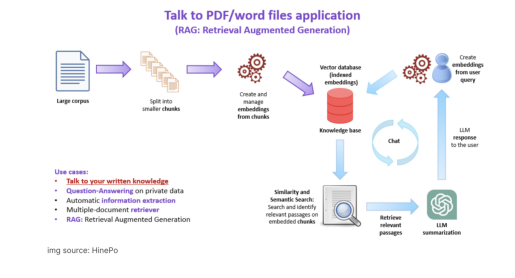

In [2]:
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt

# Mount Google Drive
#drive.mount('/content/drive')

# Path to the image file in your Google Drive
image_path = '/content/drive/MyDrive/DE_Individual_Project/RAG_Architecture.png'

# Open the image file
image = Image.open(image_path)

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


### Installs

In [4]:
# Path to your Google Drive
import os
google_drive_path = '/content/drive/MyDrive/DE_Individual_Project/'



files = os.listdir(google_drive_path)


# Print the list of files and directories
print("Files and directories in your Google Drive:")
for file in files:
    print(file)

Files and directories in your Google Drive:
RAG_Architecture.png
harry-potter-vectordb
input


In [5]:
%%time

from IPython.display import clear_output

! pip install sentence_transformers==2.2.2

! pip install -qq -U langchain
! pip install -qq -U tiktoken
! pip install -qq -U pypdf
! pip install -qq -U faiss-gpu
! pip install -qq -U InstructorEmbedding

! pip install -qq -U transformers
! pip install -qq -U accelerate
! pip install -qq -U bitsandbytes

clear_output()

CPU times: user 329 ms, sys: 36.3 ms, total: 365 ms
Wall time: 52.4 s


### Imports

In [6]:
%%time

import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

### loaders
from langchain.document_loaders import PyPDFLoader, DirectoryLoader

### splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

### prompts
from langchain import PromptTemplate, LLMChain

### vector stores
from langchain.vectorstores import FAISS

### models
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings

### retrievers
from langchain.chains import RetrievalQA

import torch
import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)

clear_output()

CPU times: user 7.03 s, sys: 996 ms, total: 8.03 s
Wall time: 11.3 s


In [7]:
print('langchain:', langchain.__version__)
print('torch:', torch.__version__)
print('transformers:', transformers.__version__)

langchain: 0.1.14
torch: 2.2.1+cu121
transformers: 4.39.3


In [8]:
sorted(glob.glob('/content/drive/MyDrive/DE_Individual_Project/Input/HP_Books/*'))

[]

### CFG
- CFG class enables easy and organized experimentation

In [9]:
class CFG:
    # LLMs
    model_name = 'llama2-13b-chat' # wizardlm, llama2-7b-chat, llama2-13b-chat, mistral-7B
    temperature = 0
    top_p = 0.95
    repetition_penalty = 1.15

    # splitting
    split_chunk_size = 800
    split_overlap = 0

    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'

    # similar passages
    k = 6

    # paths
    PDFs_path = '/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/'
    Embeddings_path =  '/content/drive/MyDrive/DE_Individual_Project/input/faiss-hp-sentence-transformers'
    Output_folder = '/content/drive/MyDrive/DE_Individual_Project/harry-potter-vectordb'

### Define model

In [10]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'

        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True
        )

        max_len = 1024

    elif model == 'llama2-7b-chat':
        model_repo = 'daryl149/llama-2-7b-chat-hf'

        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )

        max_len = 2048

    elif model == 'llama2-13b-chat':
        model_repo = 'daryl149/llama-2-13b-chat-hf'

        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )

        max_len = 2048 # 8192

    elif model == 'mistral-7B':
        model_repo = 'mistralai/Mistral-7B-v0.1'

        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
        )

        max_len = 1024

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [11]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

clear_output()

CPU times: user 11.1 s, sys: 12.9 s, total: 24 s
Wall time: 1min 57s


In [12]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


### 🤗 Pipeline
- Hugging Face Pipeline

In [13]:
### hugging face pipeline
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
#     do_sample = True,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

### langchain pipeline
llm = HuggingFacePipeline(pipeline = pipe)

In [14]:
llm

HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x7e8032806620>)

In [15]:
%%time
### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of cool potions and explain what they do"
llm.invoke(query)

CPU times: user 33.3 s, sys: 293 ms, total: 33.5 s
Wall time: 36.9 s


'Give me 5 examples of cool potions and explain what they do.\n\nSure thing! Here are five examples of cool potions that you might find in a fantasy world, along with their effects:\n\n1. Potion of Healing: This potion restores health to the drinker, healing wounds and injuries. It might also grant temporary immunity to future damage or disease.\n2. Potion of Strength: This potion grants the drinker increased physical strength and endurance for a short period of time, allowing them to lift heavier objects, run faster, and fight longer.\n3. Potion of Speed: This potion allows the drinker to move at incredible speeds for a short period of time, making it easier to escape danger or chase down enemies.\n4. Potion of Invisibility: This potion makes the drinker temporarily invisible, allowing them to sneak past guards, avoid detection by monsters, or steal valuable items without being caught.\n5. Potion of Flight: This potion gives the drinker the ability to fly for a short period of time, a

### 🦜🔗 Langchain
- Multiple document retriever with LangChain

In [16]:
CFG.model_name

'llama2-13b-chat'

### Loader
- Directory loader for multiple files
- This step is not necessary if you are just loading the vector database
- This step is necessary if you are creating embeddings. In this case you need to:
   - load de PDF files split into chunks
   - create embeddings
   - save the embeddings in a vector store
   - After that you can just load the saved embeddings to do -- similarity search with the user query, and then use the LLM to answer the question

In [17]:
%%time

loader = DirectoryLoader(
    CFG.PDFs_path,
    glob="./*.pdf",
    loader_cls=PyPDFLoader,
    show_progress=True,
    use_multithreading=True
)

documents = loader.load()

100%|██████████| 7/7 [00:51<00:00,  7.41s/it]

CPU times: user 51.1 s, sys: 1.17 s, total: 52.3 s
Wall time: 51.9 s


In [18]:
print(f'We have {len(documents)} books in total')

We have 7 books in total


In [20]:
documents[0]



[Document(page_content=' ', metadata={'source': "/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP1 - Harry Potter and the Sorcerer's Stone.pdf", 'page': 0}),
 Document(page_content='', metadata={'source': "/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP1 - Harry Potter and the Sorcerer's Stone.pdf", 'page': 1}),
 Document(page_content=' ', metadata={'source': "/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP1 - Harry Potter and the Sorcerer's Stone.pdf", 'page': 2}),
 Document(page_content=' ', metadata={'source': "/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP1 - Harry Potter and the Sorcerer's Stone.pdf", 'page': 3}),
 Document(page_content=' \n        \nHarry Potter \nAnd the  Sorcerer’s Stone \n \n \n ', metadata={'source': "/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP1 - Harry Potter and the Sorcerer's Stone.pdf", 'page': 4}),
 Document(page_content=' \n        \nALSO BY J . K. ROWLING  \nHarry Potter and

### Splitter
- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- RecursiveCharacterTextSplitter

### Create Embeddings

- Embed and store the texts in a Vector database (FAISS)
- [LangChain Vector Stores docs](https://langchain.readthedocs.io/en/latest/vector_stores.html)
- [FAISS - langchain](https://github.com/facebookresearch/faiss)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks - paper Aug/2019](https://arxiv.org/abs/1908.10084)
- This is a nice 4 minutes [video about vector stores](https://www.youtube.com/watch?v=ue_KewpQVHg)


- If you use Chroma vector store it will take ~35 min to create embeddings
- If you use FAISS vector store on GPU it will take just ~3 min


We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search.

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from here.


In [21]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.split_chunk_size,
    chunk_overlap = CFG.split_overlap
)

#texts = text_splitter.split_documents(documents)

# Split the documents into chunks
texts = []
for document_list in documents:
    # Split each document in the list using the text splitter
    split_texts = text_splitter.split_documents(document_list)
    # Extend the list of texts with the split texts
    texts.extend(split_texts)



print(f'We have created {len(texts)} chunks from {len(documents)} books')

We have created 10903 chunks from 7 books


In [22]:
%%time

### we create the embeddings only if they do not exist yet
if not os.path.exists(CFG.Embeddings_path + '/index.faiss'):

    ### download embeddings model
    embeddings = HuggingFaceInstructEmbeddings(
        model_name = CFG.embeddings_model_repo,
        model_kwargs = {"device": "cuda"}
    )

    ### create embeddings and DB
    vectordb = FAISS.from_documents(
        documents = texts,
        embedding = embeddings
    )

    ### persist vector database
    vectordb.save_local(f"{CFG.Output_folder}/faiss_index_hp") # save in output folder
    vectordb.save_local(f"{CFG.Embeddings_path}/faiss_index_hp") # save in input folder

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 29.6 s, sys: 822 ms, total: 30.4 s
Wall time: 39.6 s


### Load vector database
 - After saving the vector database, we need to load from google drive or database we will be saving input embedding path.

- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [55]:
import os
from langchain_community.vectorstores.faiss import FAISS

embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

# Set the flag to allow dangerous deserialization
allow_dangerous_deserialization = True

# Load local vector database with dangerous deserialization enabled
vectordb = FAISS.load_local(
    CFG.Embeddings_path + '/faiss_index_hp',
    embeddings,  # Assuming `embeddings` is an Embeddings object
    allow_dangerous_deserialization=allow_dangerous_deserialization
)




load INSTRUCTOR_Transformer
max_seq_length  512


In [56]:
### test if vector DB was loaded correctly
vectordb.similarity_search('magic creatures')

[Document(page_content='says Draco Malfoy, a fourth-year student. “We all hate Hagrid, but we’re just too scared to say \nanything.” \nHagrid has no intention of ceasing his campaign \nof intimidation, however. In conversation with a \nDaily Prophet  reporter last month, he admitted \nbreeding creatures he has dubbed “Blast-Ended \nSkrewts,” highly dangerous crosses between manti-\ncores and fire-crabs. The creation of new breeds of magical creature is, of course, an activity usually \nclosely observed by the Department for the Regu-\nlation and Control of Magical Creatures. Hagrid, however, considers himself to be above such petty \nrestrictions.', metadata={'source': '/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP4 - Harry Potter and the Goblet of Fire.pdf', 'page': 453}),
 Document(page_content='but I’ve heard stuff about charms wearing off cloaks when they get \nold, or them being ripped apart by spells so they’ve got holes in.', metadata={'source': '/content/drive/

### Prompt Template
- Custom prompt

In [57]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"]
)

### Retriever chain
- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)


In [58]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever,
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

In [59]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

[Document(page_content='would warn Hagrid myself, but I am  banished — it would be unwise \nfor me to go too near the forest now — Hagrid has troubles enough, \nwithout a centaurs’ battle.” \n“But — what’s Hagrid attempting to do?” said Harry nervously. \nFirenze looked at Harry impassively. \n“Hagrid has recently rendered me a great service,” said Firenze,', metadata={'source': '/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP5 - Harry Potter and the Order of the Phoenix.pdf', 'page': 619}),
 Document(page_content='says Draco Malfoy, a fourth-year student. “We all hate Hagrid, but we’re just too scared to say \nanything.” \nHagrid has no intention of ceasing his campaign \nof intimidation, however. In conversation with a \nDaily Prophet  reporter last month, he admitted \nbreeding creatures he has dubbed “Blast-Ended \nSkrewts,” highly dangerous crosses between manti-\ncores and fire-crabs. The creation of new breeds of magical creature is, of course, an activity usually

In [60]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

[Document(page_content='would warn Hagrid myself, but I am  banished — it would be unwise \nfor me to go too near the forest now — Hagrid has troubles enough, \nwithout a centaurs’ battle.” \n“But — what’s Hagrid attempting to do?” said Harry nervously. \nFirenze looked at Harry impassively. \n“Hagrid has recently rendered me a great service,” said Firenze,', metadata={'source': '/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP5 - Harry Potter and the Order of the Phoenix.pdf', 'page': 619}),
 Document(page_content='when he had been told where he wa s going, and Hagrid was one of \nthe bravest people Harry knew.', metadata={'source': '/content/drive/MyDrive/DE_Individual_Project/input/HP_Books/HP3 - Harry Potter and the Prisoner of Azkaban.pdf', 'page': 53}),
 Document(page_content='CHAPTER  THIRTEEN \n\x91 198 \x91 nothing better than a pet drag on, as Harry, Ron, and Hermione \nknew only too well — he had owned one for a brief period during \ntheir first year, a vicious

### Post-process outputs
- Format llm response
- Cite sources (PDFs)
- Change width parameter to format the output

In [61]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])

    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4]
            + ' - page: '
            + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )

    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [62]:
def llm_ans(query):
    start = time.time()

    llm_response = qa_chain.invoke(query)
    ans = process_llm_response(llm_response)

    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

### Ask questions
- Question Answering from multiple documents
- Invoke QA Chain
- Talk to your data

In [63]:
CFG.model_name

'llama2-13b-chat'

In [64]:
query = "Which challenges does Harry face during the Triwizard Tournament?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

“Speak for yourself,” said George  shortly. “You’ll try and get in,
won’t you, Harry?”
Harry thought briefly of Dumble dore’s insistence that nobody
under seventeen should submit th eir name, but then the wonder-
ful picture of himself winning the Triwizard Tournament filled his

whether it had anything to do with entering the Triwizard Tournament.
As Harry watched, George shook his head at Fred, scratched out
something with his quill, and said, in a very quiet voice that never-

won by more than three hundred points, the scenes of euphoria
and a nice loud after-match party might be just as good as a hearty
swig of Felix Felicis.
In the midst of all his preoccupa tions, Harry had not forgotten
his other ambition: finding out wh a t  M a l f o y  w a s  u p  t o  i n  t h e

that 

In [65]:
query = "Is Malfoy an ally of Voldemort?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

seemed to exist to do Malfoy’s bidding. They were  both wide and

ter directed toward finding and aiding your master?”
“My Lord, I was constantly on th e alert,” came Lucius Malfoy’s
voice swiftly from beneath the h ood. “Had there been any sign
from you, any whisper of your wh ereabouts, I would have been at
your side immediately, nothin g could have prevented me —”
“And yet you ran from my Mark, when a faithful Death Eater
sent it into the sky last summer?” said Voldemort lazily, and Mr.
Malfoy stopped talking abruptly. “Yes, I know all about that, Lu-
cius. . . . You have disappointed me. . . . I expect more faithful ser-
vice in the future.”
“Of course, my Lord, of course. . . . You are merciful, thank
you. . . .”
Voldemort moved on, and stopped,  staring at the space — large

In [66]:
query = "What are horcrux?"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

HORCRUXES
 497  tone, the careful flattery, none of it overdone. He, Harry, had had
too much experience of trying to  wheedle information out of re-
luctant people not to recognize a ma ster at work. He could tell that
Riddle wanted the information ve ry, very much; perhaps had been
working toward this moment for weeks.
“Well,” said Slughorn, not lookin g at Riddle, bu t fiddling with
the ribbon on top of his box of crystalized pineapple, “well, it can’t hurt to give you an overview, of co urse. Just so that you understand
the term. A Horcrux is the word us ed for an object in which a per-
son has concealed part  of their soul.”
“I don’t quite understand how th at works, though, sir,” said
Riddle.
His voice was carefully controll ed, but Harry could sense his
excitement.

“Why 

In [67]:
query = "Give me 5 examples of cool potions and explain what they do"
print(llm_ans(query))


Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

to remember the ingredients in complicated potions, learn charms

open potion kit, pulling out jars and pouches, while the terrible

cramming Ron’s copy of Advanced Potion-Making  into his bag as he
did so. A minute later, he was back  in front of Snape, who held out
his hand wordlessly for Harry’s schoolbag. Harry handed it over, panting, a searing pain in  his chest, and waited.
One by one, Snape extracted Harry’s books and examined them.
Finally, the only book left was the Potions book, which he looked
at very carefully before speaking.
“This is your copy of Advanced Potion-Making,  is it, Potter?”
“Yes,” said Harry, still breathing hard.
“You’re quite sure of that, are you, Potter?”
“Yes,” said Harry, with  a touch more defiance.
“This is the copy of Advanced Potion-Making  t

### Gradio Chat UI

- Create a chat UI with Gradio
- ChatInterface docs
- The notebook should be running if you want to use the chat interface

In [68]:
 import locale
 locale.getpreferredencoding = lambda: "UTF-8"

In [69]:
! pip install --upgrade gradio -qq
clear_output()

In [70]:
import gradio as gr
print(gr.__version__)

4.25.0


In [72]:
def predict(message, history):
  output = message # debug mode

  output = str(llm_ans(message)).replace("\n", "<br/>")
  return output


demo = gr.ChatInterface(
      predict,
      title = f' Open-Source LLM ({CFG.model_name}) for Harry Potter Question Answering'
       )


demo.queue()
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://96196d2c4cc410fc4a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
